# Notebook 01, v3: Подготовка данных для поиска крупномасштабных аномалий

### Введение

Этот ноутбук представляет собой третью, наиболее научно строгую итерацию нашего конвейера подготовки данных. После анализа результатов предыдущих этапов мы вносим два фундаментальных методологических изменения, чтобы перейти от общего поиска аномалий к целенаправленному поиску **крупномасштабных анизотропий** — нарушений изотропности Вселенной, таких как "CMB cold spot" или "Axis of evil".

**Ключевые изменения в этом подходе:**

 **Увеличение размера патча до 64x64:** Чтобы модель могла "увидеть" более слабые, но крупномасштабные структуры, особенно в "шумных" каналах поляризации (Q и U), мы увеличиваем размер каждого патча в четыре раза.
 **Увеличение количества уникальных образцов:** Чтобы компенсировать отсутствие аугментации и обеспечить модели достаточное количество данных для обучения, мы увеличиваем количество генерируемых уникальных патчей до 10 000.

Этот подход вычислительно более требователен, но он позволяет нам искать аномалии "честно", не делая априорных предположений о свойствах Вселенной, что превращает наш проект в настоящее научное исследование.

### Step 1: Environment Setup

In this cell, we import all the necessary Python libraries for this notebook. We also define the file paths we'll use, centralizing them in one place to make the code cleaner and easier to manage.

-   **`os`**: For interacting with the file system (e.g., creating directories).
-   **`requests`**: A robust library for making HTTP requests to download our data.
-   **`tqdm`**: A utility for creating smart, informative progress bars.
-   **`numpy`**: The fundamental library for numerical operations in Python.
-   **`healpy`**: The core library for processing HEALPix data.
-   **`matplotlib.pyplot`**: The primary library for creating plots and visualizations.
 We mount Google Drive for persistent storage, install the `healpy` library for CMB data manipulation, and import essential libraries.

In [1]:
# --- Mount Google Drive ---
# This command connects the Colab virtual machine to your personal Google Drive.
# It's essential for saving data, models, and notebooks, ensuring our work
# persists between sessions. You will be prompted for authorization.
from google.colab import drive
drive.mount('/content/drive')

# --- Install HEALPy --- The 'healpy' library is a powerful tool specifically
# designed for working with data on a sphere. We will use it to read, visualize,
# and manipulate the CMB sky map.
!pip install healpy

# --- Standard Library Imports ---
import os
import requests
from tqdm.auto import tqdm

# --- Scientific Computing Imports ---
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# --- Path Definitions ---
# Define the absolute path to our project folder on Google Drive.
project_path = '/content/drive/My Drive/CosmicLegacy'
# Define a dedicated sub-folder for storing raw and processed data.
data_path = os.path.join(project_path, 'data')
# Create the data directory if it doesn't already exist.
os.makedirs(data_path, exist_ok=True)

print(f"Project path is set to: {project_path}")
print(f"Data will be stored in: {data_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 78.5 MB/s eta 0:00:00
Project path is set to: /content/drive/My Drive/CosmicLegacy
Data will be stored in: /content/drive/My Drive/CosmicLegacy/data


### Step 2: Data Acquisition

Now we download our two essential data files. We will download them only if they don't already exist in our Google Drive folder.

**Important Note on Data Schema:** The FITS files from the Planck mission are stored using the **NESTED** pixel ordering scheme. This is a critical detail that we must account for when processing the data in subsequent steps.

1.  **CMB Map (`planck_cmb_map.fits`):** This is the component-separated SMICA map from the Planck 2018 data release. It represents the "cleaned" full-sky view of the CMB temperature and polarization, where foreground signals from our own galaxy have been mathematically subtracted.

In [2]:
# --- Conditional Download for Main CMB Map ---
# Note: This map uses the NESTED pixel ordering scheme.
map_url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits"
map_filename = "COM_CMB_IQU-smica_2048_R3.00_full.fits"
map_filepath = os.path.join(data_path, map_filename)

if not os.path.exists(map_filepath):
    print(f"Main CMB map not found. Starting download...")
    try:
        response = requests.get(map_url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=map_filename)
        with open(map_filepath, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
        print(f"Download complete! File saved to {map_filepath}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
else:
    print(f"Main CMB map already exists: {map_filepath}")


Main CMB map already exists: /content/drive/My Drive/CosmicLegacy/data/COM_CMB_IQU-smica_2048_R3.00_full.fits


2.  **Confidence Mask (`COM_Mask_...`):** This is the official mask for the data release. It's a binary map that tells us which pixels on the sky are considered "clean" enough for high-precision cosmological analysis, effectively blocking out the brightest parts of the Milky Way. This mask also uses the **NESTED** scheme.

In [3]:
# --- Conditional Download for Mask File ---
# Note: This mask also uses the NESTED pixel ordering scheme.
mask_url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
mask_filename = "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
mask_filepath = os.path.join(data_path, mask_filename)

if not os.path.exists(mask_filepath):
    print(f"Official R3 mask not found. Starting download...")
    try:
        response = requests.get(mask_url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=mask_filename)
        with open(mask_filepath, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
        print(f"Download complete! File saved to {mask_filepath}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
else:
    print(f"Official R3 mask already exists: {mask_filepath}")


Official R3 mask already exists: /content/drive/My Drive/CosmicLegacy/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits


### Step 3: Data Loading and Full Visualization

This step loads all the data required for our advanced analysis. We need four distinct maps: the Temperature map (I), the two Polarization maps (Q and U), and the galactic mask. To provide a complete overview of our source data, we will visualize all four maps on a single comprehensive plot. This serves as a critical verification step and provides a clear record of our inputs.


Loading all necessary maps from disk...
All I, Q, U, and Mask maps loaded successfully.
Visualizing all source maps...


/tmp/ipython-input-7-2850023793.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


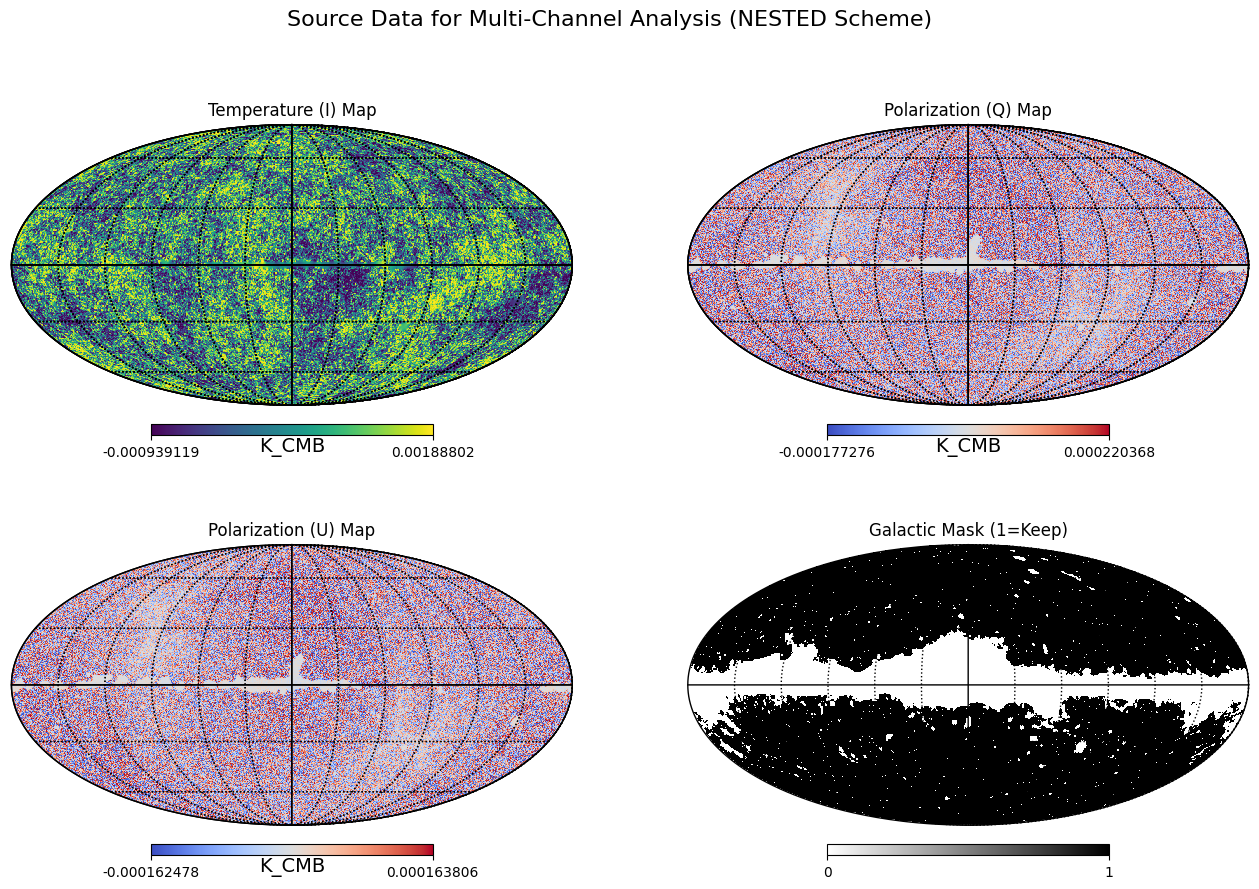

In [7]:
# --- Load All Necessary Maps from Disk ---
print("\nLoading all necessary maps from disk...")

# Определяем пути к файлам
map_filepath = os.path.join(data_path, "COM_CMB_IQU-smica_2048_R3.00_full.fits")
mask_filepath = os.path.join(data_path, "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits")

try:
    # ИСПРАВЛЕНИЕ: Загружаем все три карты (I, Q, U) одним вызовом для эффективности
    # Явно указываем, что карты в схеме NESTED
    cmb_map_I, cmb_map_Q, cmb_map_U = hp.read_map(map_filepath, field=(0, 1, 2), nest=True)

    # ИСПРАВЛЕНИЕ: Исправлена опечатка в имени переменной (mask_filepath)
    # Явно указываем, что маска также в схеме NESTED
    galactic_mask = hp.read_map(mask_filepath, nest=True)

    print("All I, Q, U, and Mask maps loaded successfully.")

except Exception as e:
    print(f"An error occurred while loading maps: {e}")


# --- Visualize All Four Maps ---
print("Visualizing all source maps...")
# Создаём большую фигуру для сетки графиков 2x2
plt.figure(figsize=(16, 10))

# --- Plot Temperature (I) Map ---
plt.subplot(2, 2, 1)
# ИСПРАВЛЕНИЕ: Добавляем nest=True для корректной визуализации
hp.mollview(cmb_map_I, title="Temperature (I) Map", unit="K_CMB", norm='hist', cmap='viridis', hold=True, notext=True, nest=True)
hp.graticule()

# --- Plot Polarization (Q) Map ---
plt.subplot(2, 2, 2)
# ИСПРАВЛЕНИЕ: Добавляем nest=True для корректной визуализации
hp.mollview(cmb_map_Q, title="Polarization (Q) Map", unit="K_CMB", norm='hist', cmap='coolwarm', hold=True, notext=True, nest=True)
hp.graticule()

# --- Plot Polarization (U) Map ---
plt.subplot(2, 2, 3)
# ИСПРАВЛЕНИЕ: Добавляем nest=True для корректной визуализации
hp.mollview(cmb_map_U, title="Polarization (U) Map", unit="K_CMB", norm='hist', cmap='coolwarm', hold=True, notext=True, nest=True)
hp.graticule()

# --- Plot Galactic Mask ---
plt.subplot(2, 2, 4)
# ИСПРАВЛЕНИЕ: Добавляем nest=True для корректной визуализации
hp.mollview(galactic_mask, title="Galactic Mask (1=Keep)", cmap='gray_r', hold=True, notext=True, nest=True)
hp.graticule()

# Добавляем общий заголовок
plt.suptitle("Source Data for Multi-Channel Analysis (NESTED Scheme)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Шаг 4: Автоматизированная генерация частей датасета

1. Цель
Создать набор данных из 10 000 уникальных, ориентированных и научно-чистых патчей реликтового излучения. Каждый патч имеет размер 64x64 пикселя и содержит 3 канала (Температура I, Поляризация Q, Поляризация U).
2. Ключевые Принципы и их Реализация
А. Научная строгость (The "Safeguard")

Проблема: Просто выбрать центр патча в "чистой" зоне неба недостаточно. Края патча могут "залезть" на область, загрязненную излучением нашей Галактики, что внесет в данные ложный сигнал.

Решение: Мы внедрили двойной контроль:

Выбор кандидатов: Изначальный список пикселей-кандидатов для центров патчей выбирается только из идеально чистых зон, где значение маски равно 1.0. Это резко повышает шансы на успех.

Проверка каждого патча (is_patch_clean): Перед тем как сохранить патч, скрипт создает временную проекцию маски для этой же области неба. Затем он проверяет, что минимальное значение в этом патче маски больше 0.9. Только если весь патч целиком находится в чистой зоне, он принимается в набор данных.


In [8]:
# --- Установка библиотек ---
!pip install healpy

# --- Импорты ---
import tensorflow as tf
import numpy as np
import healpy as hp
import json
import os
import time
from google.colab import drive
import gc
from healpy.projector import GnomonicProj
from tqdm.auto import tqdm # Используем tqdm для наглядного прогресс-бара

# --- Шаг 1: Монтирование диска ---
print("Mounting Google Drive...")
drive.mount('/content/drive')

# --- Шаг 2: Конфигурация ---
print("Configuring paths and parameters...")
drive_path = '/content/drive/My Drive/CosmicLegacy'
output_dir = os.path.join(drive_path, 'data_v3_64x64')
stats_file_path = os.path.join(output_dir, 'normalization_stats_3_channel.json')
final_tfrecord_path = os.path.join(output_dir, 'cmb_patches_64x64_final.tfrecord') # Путь к финальному файлу
patch_size = 64
nside = 2048
total_patches = 10000 # Общее количество патчей, которое мы хотим получить

# Создаём переменную для пути к исходным данным для ясности
data_path = os.path.join(drive_path, 'data')

# Создаём выходную директорию, если она не существует
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory is set to: {output_dir}")
print(f"Data path is set to: {data_path}")


# --- Шаг 3: Загрузка карт CMB и маски ---
print("Loading CMB maps (I, Q, U) and galactic mask...")
i_map_path = os.path.join(data_path, 'COM_CMB_IQU-smica_2048_R3.00_full.fits')
mask_path = os.path.join(data_path, 'COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

# Явно указываем, что карты в схеме NESTED
i_map, q_map, u_map = hp.read_map(i_map_path, field=(0, 1, 2), nest=True)
mask = hp.read_map(mask_path, nest=True)
print("Maps and mask loaded successfully.")


# --- Шаг 4: Определение вспомогательных функций (оптимизировано) ---
print("Defining optimized helper functions...")

# Создаём lambda-функцию для проекции один раз
# Карты в NESTED, поэтому vec2pix тоже должен использовать nest=True
vec2pix_func = lambda x, y, z: hp.vec2pix(nside, x, y, z, nest=True)

def get_gnomonic_patch(map_data, rot_params, patch_size):
    """Извлекает одноканальный патч с использованием прямой проекции."""
    proj = GnomonicProj(rot=rot_params, xsize=patch_size, reso=1.5)
    return np.nan_to_num(proj.projmap(map_data, vec2pix_func))

# ИЗМЕНЕНИЕ: Возвращаем функцию-предохранитель для ясности кода
def is_patch_clean(mask_map, rot_params, patch_size):
    """SAFEGUARD FUNCTION: Checks if the entire gnomonic patch is within the valid mask area."""
    mask_patch = get_gnomonic_patch(mask_map, rot_params, patch_size)
    return np.min(mask_patch) > 0.9

def _bytes_feature(value):
    """Возвращает bytes_list из строки/байтов."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(patch):
    """Создаёт сообщение tf.train.Example для записи в файл."""
    feature = {'patch': _bytes_feature(patch.astype(np.float32).tobytes())}
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# --- Шаг 5: Генерация полного датасета за один проход ---
print("\n--- Starting Automated Dataset Generation ---")

# --- Загрузка или вычисление статистики для нормализации ---
print("Attempting to load or calculate normalization stats...")
try:
    if os.path.exists(stats_file_path) and os.path.getsize(stats_file_path) > 0:
        with open(stats_file_path, 'r') as f:
            stats = json.load(f)
        print(f"Successfully loaded existing normalization stats from {stats_file_path}")
    else:
        raise FileNotFoundError
except (FileNotFoundError, json.JSONDecodeError) as e:
    print(f"Stats file issue ({type(e).__name__}). Regenerating...")
    valid_pixels = np.where(mask > 0.9)[0]
    sample_pixels = np.random.choice(valid_pixels, 20000, replace=False)
    i_vals, q_vals, u_vals = i_map[sample_pixels], q_map[sample_pixels], u_map[sample_pixels]
    stats = {
        'I': {'mean': float(np.mean(i_vals)), 'std': float(np.std(i_vals))},
        'Q': {'mean': float(np.mean(q_vals)), 'std': float(np.std(q_vals))},
        'U': {'mean': float(np.mean(u_vals)), 'std': float(np.std(u_vals))},
    }
    with open(stats_file_path, 'w') as f:
        json.dump(stats, f, indent=4)
    print(f"Normalization stats calculated and saved to {stats_file_path}")

mean_i, std_i = stats['I']['mean'], stats['I']['std']
mean_q, std_q = stats['Q']['mean'], stats['Q']['std']
mean_u, std_u = stats['U']['mean'], stats['U']['std']

# --- Создание пула пикселей-кандидатов ---
candidate_pool_size = int(total_patches * 1.7) # Создаём с запасом
print("Selecting candidate pixels from perfectly clean areas (mask == 1.0)...")
valid_pixels = np.where(mask == 1.0)[0]
print(f"Found {len(valid_pixels)} perfectly clean pixels.")

if len(valid_pixels) < candidate_pool_size:
    raise ValueError(f"Not enough perfectly clean pixels to generate the dataset. Found {len(valid_pixels)}, but need {candidate_pool_size}.")

pixel_indices = np.random.choice(valid_pixels, candidate_pool_size, replace=False)

# --- Основной цикл генерации ---
print(f"Collecting {total_patches} clean patches...")
start_time = time.time()
patches_collected = 0
attempts = 0

with tf.io.TFRecordWriter(final_tfrecord_path) as writer:
    with tqdm(total=total_patches, desc="Generating Patches") as pbar:
        while patches_collected < total_patches:
            if attempts >= len(pixel_indices):
                print("\n\nFATAL ERROR: Ran out of candidate pixels!")
                break

            pix_idx = pixel_indices[attempts]
            attempts += 1

            theta, phi = hp.pix2ang(nside, pix_idx, nest=True)
            rot_params = (np.rad2deg(phi), 90.0 - np.rad2deg(theta))

            # ИЗМЕНЕНИЕ: Используем явный вызов функции-предохранителя
            if is_patch_clean(mask, rot_params, patch_size):
                patch_i = get_gnomonic_patch(i_map, rot_params, patch_size)
                patch_q = get_gnomonic_patch(q_map, rot_params, patch_size)
                patch_u = get_gnomonic_patch(u_map, rot_params, patch_size)

                patch_i = (patch_i - mean_i) / std_i
                patch_q = (patch_q - mean_q) / std_q
                patch_u = (patch_u - mean_u) / std_u

                patch_iqu = np.stack([patch_i, patch_q, patch_u], axis=-1)

                writer.write(serialize_example(patch_iqu))
                patches_collected += 1
                pbar.update(1)

end_time = time.time()
rejection_rate = (1 - (patches_collected / attempts)) * 100 if attempts > 0 else 0

print(f"\n--- DATASET GENERATION COMPLETE! ---")
print(f"Successfully wrote {patches_collected} patches to {final_tfrecord_path}")
print(f"Total time: {end_time - start_time:.2f} seconds.")
print(f"Total attempts: {attempts}. Rejection rate: {rejection_rate:.2f}%")


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Configuring paths and parameters...
Output directory is set to: /content/drive/My Drive/CosmicLegacy/data_v3_64x64
Data path is set to: /content/drive/My Drive/CosmicLegacy/data
Loading CMB maps (I, Q, U) and galactic mask...
Maps and mask loaded successfully.
Defining optimized helper functions...

--- Starting Automated Dataset Generation ---
Attempting to load or calculate normalization stats...
Stats file issue (FileNotFoundError). Regenerating...
Normalization stats calculated and saved to /content/drive/My Drive/CosmicLegacy/data_v3_64x64/normalization_stats_3_channel.json
Selecting candidate pixels from perfectly clean areas (mask == 1.0)...
Found 39229084 perfectly clean pixels.


Generating Patches:   0%|          | 0/10000 [00:00<?, ?it/s]


--- DATASET GENERATION COMPLETE! ---
Successfully wrote 10000 patches to /content/drive/My Drive/CosmicLegacy/data_v3_64x64/cmb_patches_64x64_final.tfrecord
Total time: 61.28 seconds.
Total attempts: 14626. Rejection rate: 31.63%


### Шаг5: Comprehensive Verification of Data Integrity

**Goal:** To rigorously confirm the integrity, correctness, and sequential order of the final `cmb_patches_64x64_final.tfrecord` dataset.

**Methodology:**
Instead of shuffled sampling, which destroys spatial context, we will perform a structured verification. We will read and visualize patches from three distinct sections of the file:
1.  **The Beginning:** The very first few patches.
2.  **The Middle:** Patches from the approximate midpoint of the dataset.
3.  **The End:** The last few patches.

This approach verifies three critical aspects:
- **Data Readability:** The file is not corrupt and can be parsed by TensorFlow.
- **Content Correctness:** The patches (I, Q, U channels) appear as expected.
- **Sequential Integrity:** The data is ordered as generated, which is crucial for the subsequent anomaly mapping phase (Phase 3), where the location of each patch matters.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# --- Configuration ---
# Убедимся, что переменная output_dir определена, как в ячейке 5.1
drive_path = '/content/drive/My Drive/CosmicLegacy'
output_dir = os.path.join(drive_path, 'data_v3_64x64')

# ИСПРАВЛЕНО: Используем полные пути к файлам
final_dataset_path = os.path.join(output_dir, 'cmb_patches_64x64_final.tfrecord')
stats_file_path = os.path.join(output_dir, 'normalization_stats_3_channel.json')

total_patches = 10000  # The total number of patches we generated
samples_to_show = 3    # Number of samples to show from each section

# --- Load Normalization Stats ---
print(f"Loading stats from: {stats_file_path}")
with open(stats_file_path, 'r') as f:
    stats = json.load(f)

mean_i, std_i = stats['I']['mean'], stats['I']['std']
mean_q, std_q = stats['Q']['mean'], stats['Q']['std']
mean_u, std_u = stats['U']['mean'], stats['U']['std']
print("Stats loaded successfully.")

# --- TFRecord Parsing Function ---
def parse_tfrecord_fn(example):
    feature_description = {
        'patch': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    patch = tf.io.decode_raw(example['patch'], tf.float32)
    patch = tf.reshape(patch, (64, 64, 3))
    return patch

# --- Denormalization Function for Visualization ---
def denormalize_patch(patch):
    # Ensure patch is a numpy array for processing
    p = patch.numpy() if isinstance(patch, tf.Tensor) else patch

    p_i = p[:, :, 0] * std_i + mean_i
    p_q = p[:, :, 1] * std_q + mean_q
    p_u = p[:, :, 2] * std_u + mean_u

    return p_i, p_q, p_u

# --- Function to Load and Display Samples ---
def display_samples(dataset, title):
    print(f"--- {title} ---")

    # Take the specified number of samples from the dataset
    samples = list(dataset.take(samples_to_show))

    fig, axs = plt.subplots(samples_to_show, 3, figsize=(12, 4 * samples_to_show))
    fig.suptitle(title, fontsize=16, y=1.02)

    for i, patch in enumerate(samples):
        p_i, p_q, p_u = denormalize_patch(patch)

        # Set titles for the first row only
        title_i = "Channel I (Temp)" if i == 0 else ""
        title_q = "Channel Q (Pol)" if i == 0 else ""
        title_u = "Channel U (Pol)" if i == 0 else ""

        im_i = axs[i, 0].imshow(p_i, cmap='viridis')
        axs[i, 0].set_title(title_i)
        fig.colorbar(im_i, ax=axs[i, 0], fraction=0.046, pad=0.04)

        im_q = axs[i, 1].imshow(p_q, cmap='coolwarm')
        axs[i, 1].set_title(title_q)
        fig.colorbar(im_q, ax=axs[i, 1], fraction=0.046, pad=0.04)

        im_u = axs[i, 2].imshow(p_u, cmap='coolwarm')
        axs[i, 2].set_title(title_u)
        fig.colorbar(im_u, ax=axs[i, 2], fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# --- Main Verification Logic ---
print(f"Verifying final dataset: {final_dataset_path}")
if not os.path.exists(final_dataset_path):
    print("\nОШИБКА: Финальный файл датасета не найден. Пожалуйста, запустите шаг 5.2 для его создания.")
else:
    # Create the base dataset
    base_dataset = tf.data.TFRecordDataset(final_dataset_path).map(parse_tfrecord_fn)

    # 1. Verify the BEGINNING of the dataset
    display_samples(base_dataset, "Verification: First Patches")

    # 2. Verify the MIDDLE of the dataset
    middle_point = total_patches // 2
    middle_dataset = base_dataset.skip(middle_point)
    display_samples(middle_dataset, "Verification: Middle Patches")

    # 3. Verify the END of the dataset
    # Skip to near the end to get the last few samples
    end_point = total_patches - samples_to_show
    end_dataset = base_dataset.skip(end_point)
    display_samples(end_dataset, "Verification: Last Patches")

### Conclusion

This notebook has successfully completed the advanced data preparation phase of our project. We have moved beyond a simple proof-of-concept and created a professional-grade, high-quality dataset ready for training a sophisticated anomaly detection model.

The key features of our final dataset are:
* **Multi-Channel Data:** Each patch contains three channels of information (Temperature I, Polarization Q, and Polarization U), providing our model with a complete view of the CMB signal.
* **Pre-computed Statistics:** We have calculated and saved the normalization statistics for each channel into a separate `json` file. This will streamline the preprocessing pipeline in the next notebook and ensure consistency.

The final outputs of this notebook — the main `.npy` dataset file and the `normalization_stats.json` file — form the foundation for the next, most critical stage: training a more powerful and sensitive VAE model in `02_Model_Training_v3_LargeScale.ipynb`.